# Tutorial 2: Choosing Algorithm Hyperparameters

This is the notebook for lecture https://youtu.be/HvOdfwgTPnM?si=UoYj1B4Tvu1woVtz

Load dependencies and define a number of plotting functions for use later

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars

from pysindy.utils import lorenz, lorenz_control, enzyme
import pysindy as ps

# bad code but allows us to ignore warnings
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=ODEintWarning)

C:\Users\micka\AppData\Local\Temp\ipykernel_26732\4047011907.py:21: DeprecationWarning: Please import `ODEintWarning` from the `scipy.integrate` namespace; the `scipy.integrate.odepack` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.integrate.odepack import ODEintWarning


In [2]:
# Seed the random number generators for reproducibility
np.random.seed(100)

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [3]:
# Make coefficient plot for threshold scan
def plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test):
    dt = t_test[1] - t_test[0]
    mse = np.zeros(len(threshold_scan))
    mse_sim = np.zeros(len(threshold_scan))
    for i in range(len(threshold_scan)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0, :], t_test, integrator="odeint")
        if np.any(x_test_sim > 1e4):
            x_test_sim = 1e4
        mse_sim[i] = np.sum((x_test - x_test_sim) ** 2)
    plt.figure()
    plt.semilogy(threshold_scan, mse, "bo")
    plt.semilogy(threshold_scan, mse, "b")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\lambda$", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.figure()
    plt.semilogy(threshold_scan, mse_sim, "bo")
    plt.semilogy(threshold_scan, mse_sim, "b")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\lambda$", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)

## Lorenz system
We will use the famous Lorenz system for most of the examples below:
$$ \dot{x} = \sigma (y - x),$$
$$ \dot{y} = x(\rho - z) - y, $$
$$ \dot{z} = x y - \beta z, $$
with $\sigma = 10$, $\rho = 28$, and $\beta = 8/3$.

In [4]:
# define the testing and training Lorenz data we will use for these examples
dt = 0.002

t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
t_train_span = (t_train[0], t_train[-1])
x_train = solve_ivp(
    lorenz, t_train_span, x0_train, t_eval=t_train, **integrator_keywords
).y.T

t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.array([8, 7, 15])
x_test = solve_ivp(
    lorenz, t_test_span, x0_test, t_eval=t_test, **integrator_keywords
).y.T

# define the testing and training data for the Lorenz system with control
def u_fun(t):
    return np.column_stack([np.sin(2 * t), t ** 2])


x_train_control = solve_ivp(
    lorenz_control,
    t_train_span,
    x0_train,
    t_eval=t_train,
    args=(u_fun,),
    **integrator_keywords
).y.T
u_train_control = u_fun(t_train)
x_test_control = solve_ivp(
    lorenz_control,
    t_test_span,
    x0_test,
    t_eval=t_test,
    args=(u_fun,),
    **integrator_keywords
).y.T
u_test_control = u_fun(t_test)

# Part 1: How to choose algorithm hyperparameters such as $\lambda$?

__obs__: If you are following the YouTube tutorial, note that setting the feature names is no longer done in the `SINDy` constructor. Instead, it's passed when calling the `fit` function. Otherwise, you will receive an error message.

In [5]:
# Instantiate and fit the SINDy model
feature_names = ['x', 'y', 'z']
sparse_regression_optimizer = ps.STLSQ(threshold=0)  # default is lambda = 0.1
model = ps.SINDy(optimizer=sparse_regression_optimizer)
model.fit(x_train, t=dt, feature_names = feature_names)
model.print()

(x)' = -0.001 1 + -10.005 x + 10.003 y
(y)' = -0.015 1 + 27.991 x + -0.998 y + 0.002 z + -1.000 x z
(z)' = 0.008 1 + 0.006 x + -0.004 y + -2.666 z + 0.001 x^2 + 0.999 x y


In [6]:
sparse_regression_optimizer = ps.STLSQ(threshold=0.1)
model = ps.SINDy(optimizer=sparse_regression_optimizer)
model.fit(x_train, t=dt, feature_names=feature_names)
model.print()

(x)' = -9.999 x + 9.999 y
(y)' = 27.992 x + -0.999 y + -1.000 x z
(z)' = -2.666 z + 1.000 x y


In [7]:
sparse_regression_optimizer = ps.STLSQ(threshold=1.0)
model = ps.SINDy(optimizer=sparse_regression_optimizer)
model.fit(x_train, t=dt,feature_names=feature_names)
model.print()

(x)' = -9.999 x + 9.999 y
(y)' = -2.793 x
(z)' = 0.000


__Obs__: the `squared` parameter in `mean_squared_error` is deprecated. Now, you should use the `root_mean_squared_error`. If you are following the youtube lectures, `quiet` parameter in `fit` function is deprecated.

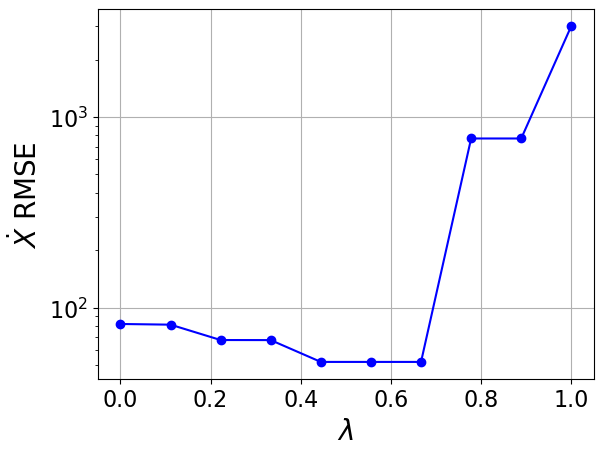

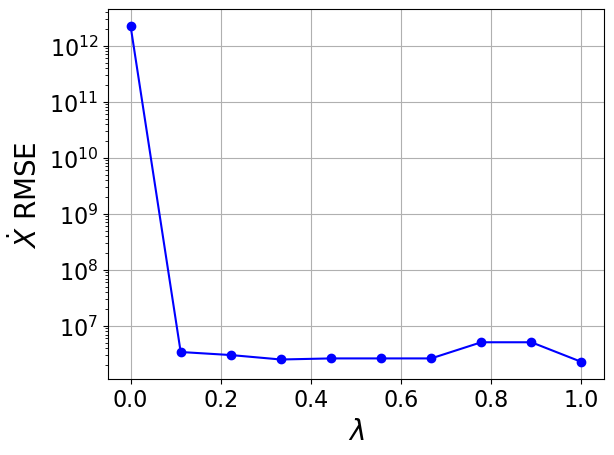

In [8]:
threshold_scan = np.linspace(0, 1.0, 10)
coefs = []
rmse = root_mean_squared_error(x_train, np.zeros(x_train.shape))
x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0,  x_train.shape)
for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.STLSQ(threshold=threshold)
    model = ps.SINDy( 
                     optimizer=sparse_regression_optimizer)
    model.fit(x_train_added_noise, t=dt, feature_names=feature_names)
    coefs.append(model.coefficients())
    
plot_pareto(coefs, sparse_regression_optimizer, model, 
            threshold_scan, x_test, t_test)

**Primary conclusions of part 1**

A type of pareto curve, generated by scanning over $\lambda$, produces a systematic way to choose the level of sparsity in a system.
Moreover, there are sharp increases as $\lambda$ increases. There are physical dropoffs because these correspond to important terms being truncated off the model!